In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json, joblib

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

df = pd.read_csv("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Data\\processed\\nfhs4_with_predictions.csv")

with open("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Data\\processed\\selected_features.json") as f:
    Selected_features = json.load(f)

TARGET = "stunting"

X_raw    = df[Selected_features].values
X_scaled = df[[f"{c}_sc" for c in Selected_features]].values

print(f" Loaded: {df.shape}")

 Loaded: (607, 38)


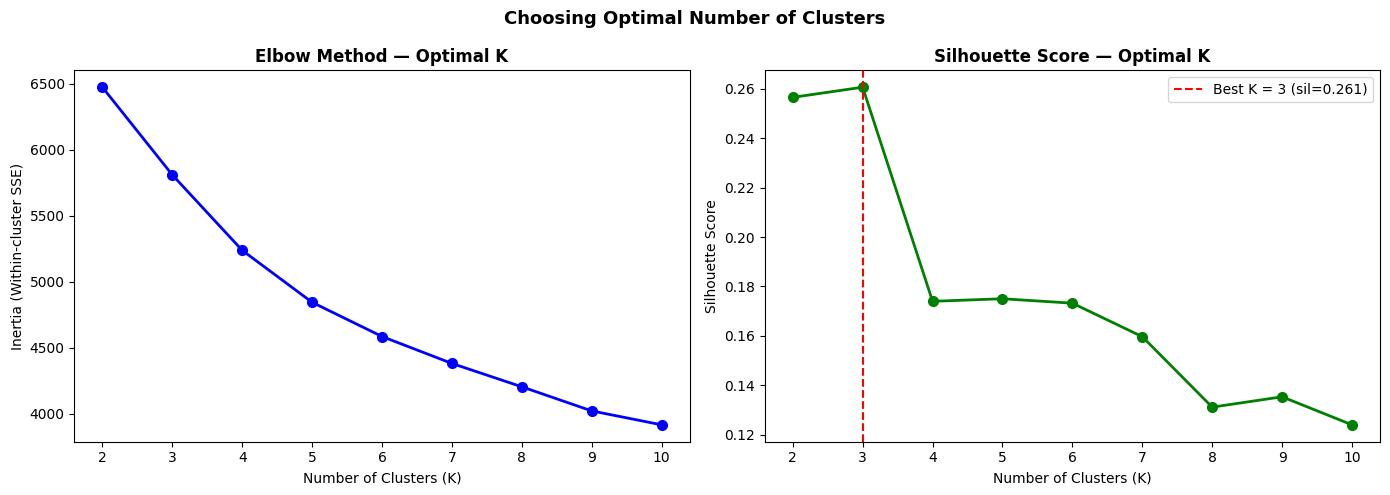


 Silhouette Scores 
  K = 2  |  Silhouette = 0.2566
  K = 3  |  Silhouette = 0.2607  best
  K = 4  |  Silhouette = 0.1740
  K = 5  |  Silhouette = 0.1750
  K = 6  |  Silhouette = 0.1732
  K = 7  |  Silhouette = 0.1597
  K = 8  |  Silhouette = 0.1311
  K = 9  |  Silhouette = 0.1353
  K = 10  |  Silhouette = 0.1240


In [9]:
# Determine optimal K using Elbow and Silhouette methods
inertias = []
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    km  = KMeans(n_clusters=k, random_state=42, n_init=20)
    lbl = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, lbl))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow
axes[0].plot(K_range, inertias, "bo-", linewidth=2, markersize=7)
axes[0].set_xlabel("Number of Clusters (K)")
axes[0].set_ylabel("Inertia (Within-cluster SSE)")
axes[0].set_title("Elbow Method — Optimal K", fontweight="bold")
axes[0].set_xticks(list(K_range))

# Silhouette
axes[1].plot(K_range, sil_scores, "go-", linewidth=2, markersize=7)
best_k = K_range[np.argmax(sil_scores)]
axes[1].axvline(best_k, color="red", linestyle="--", label=f"Best K = {best_k} (sil={max(sil_scores):.3f})")
axes[1].set_xlabel("Number of Clusters (K)")
axes[1].set_ylabel("Silhouette Score")
axes[1].set_title("Silhouette Score — Optimal K", fontweight="bold")
axes[1].set_xticks(list(K_range))
axes[1].legend()

plt.suptitle("Choosing Optimal Number of Clusters", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Outputs\\figures\\14_elbow_silhouette.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\n Silhouette Scores ")
for k, s in zip(K_range, sil_scores):
    marker = "  best" if k == best_k else ""
    print(f"  K = {k}  |  Silhouette = {s:.4f}{marker}")

In [10]:
Final_K = 3 # Chosen based on silhouette scores and interpretability

# Fit final KMeans and assign cluster labels
km_final = KMeans(n_clusters=Final_K, random_state=42, n_init=50)
df["cluster"] = km_final.fit_predict(X_scaled)

print(f" KMeans fitted with K = {Final_K}")
print(f"\n District counts per cluster ")
print(df["cluster"].value_counts().sort_index().to_string())

print(f"\n Average stunting rate per cluster ")
print(df.groupby("cluster")[TARGET].agg(["mean", "median", "std", "count"]).round(2).to_string())

 KMeans fitted with K = 3

 District counts per cluster 
cluster
0    296
1    243
2     68

 Average stunting rate per cluster 
          mean  median   std  count
cluster                            
0        30.83   29.90  8.41    296
1        43.80   44.20  6.95    243
2        33.57   34.85  7.99     68


In [11]:
# Rank clusters by average stunting rate to assign policy-relevant labels
cluster_stunting = (df.groupby("cluster")[TARGET].mean().sort_values().reset_index())
cluster_stunting["rank"] = range(len(cluster_stunting))

# Policy labels — assigned by stunting rank (lowest to highest)
POLICY_LABELS = {
    0: "Tier 1 — Low Risk (Developed)",
    1: "Tier 2 — Moderate Risk",
    2: "Tier 3 — High Risk",
    3: "Tier 4 — Critical Risk (Deprived)"}

# Map cluster number → label based on stunting rank
rank_to_label = {row["cluster"]: POLICY_LABELS[row["rank"]] for _, row in cluster_stunting.iterrows()}
df["risk_segment"] = df["cluster"].map(rank_to_label)

print(" Cluster → Risk Segment Mapping ")
for cluster_id, label in rank_to_label.items():
    mean_s = df[df["cluster"] == cluster_id][TARGET].mean()
    count  = (df["cluster"] == cluster_id).sum()
    print(f" Cluster {cluster_id} → {label}")
    print(f" Mean stunting = {mean_s:.1f}%  |  n = {count} districts\n")

 Cluster → Risk Segment Mapping 
 Cluster 0.0 → Tier 1 — Low Risk (Developed)
 Mean stunting = 30.8%  |  n = 296 districts

 Cluster 2.0 → Tier 2 — Moderate Risk
 Mean stunting = 33.6%  |  n = 68 districts

 Cluster 1.0 → Tier 3 — High Risk
 Mean stunting = 43.8%  |  n = 243 districts



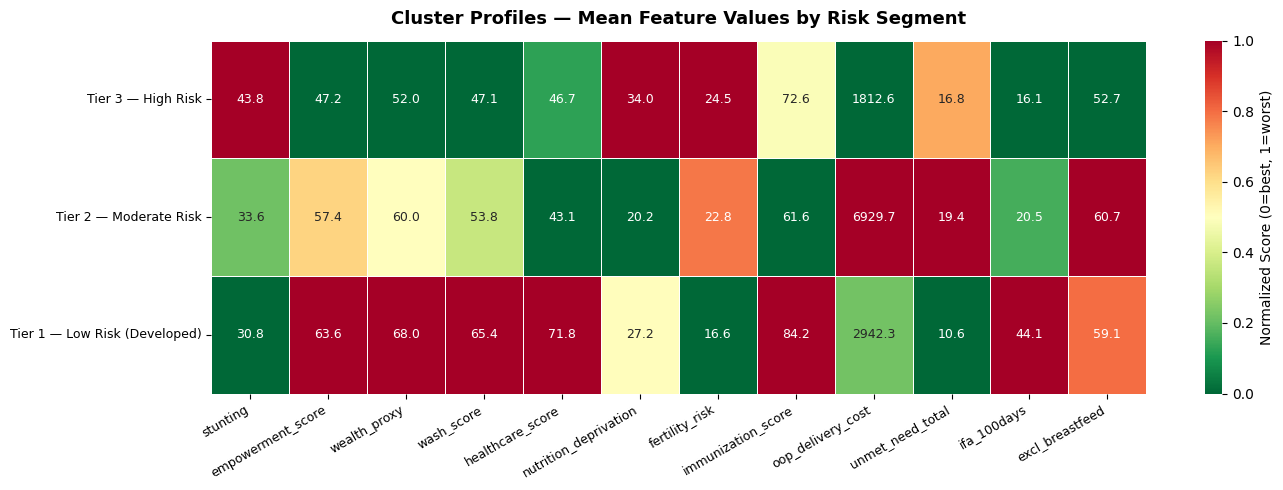

In [12]:
# Use original (unscaled) features for interpretability
Display_features = [
    "stunting", "empowerment_score", "wealth_proxy",
    "wash_score", "healthcare_score", "nutrition_deprivation",
    "fertility_risk", "immunization_score", "oop_delivery_cost",
    "unmet_need_total", "ifa_100days", "excl_breastfeed"]

cluster_profile = (df.groupby("risk_segment")[Display_features].mean().round(1))

# Sort by stunting descending (Critical at top)
cluster_profile = cluster_profile.loc[cluster_profile["stunting"].sort_values(ascending=False).index]

# Normalize each feature to 0-1 for heatmap color scaling
cluster_profile_norm = (cluster_profile - cluster_profile.min()) / \
(cluster_profile.max() - cluster_profile.min())

fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(cluster_profile_norm, annot=cluster_profile.values, fmt=".1f", cmap="RdYlGn_r", linewidths=0.5, annot_kws={"size": 9}, ax=ax, cbar_kws={"label": "Normalized Score (0=best, 1=worst)"})
ax.set_title("Cluster Profiles — Mean Feature Values by Risk Segment", fontsize=13, fontweight="bold", pad=12)
ax.set_xlabel("")
ax.set_ylabel("")
plt.xticks(rotation=30, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.savefig("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Outputs\\figures\\15_cluster_profiles.png", dpi=150, bbox_inches="tight")
plt.show()

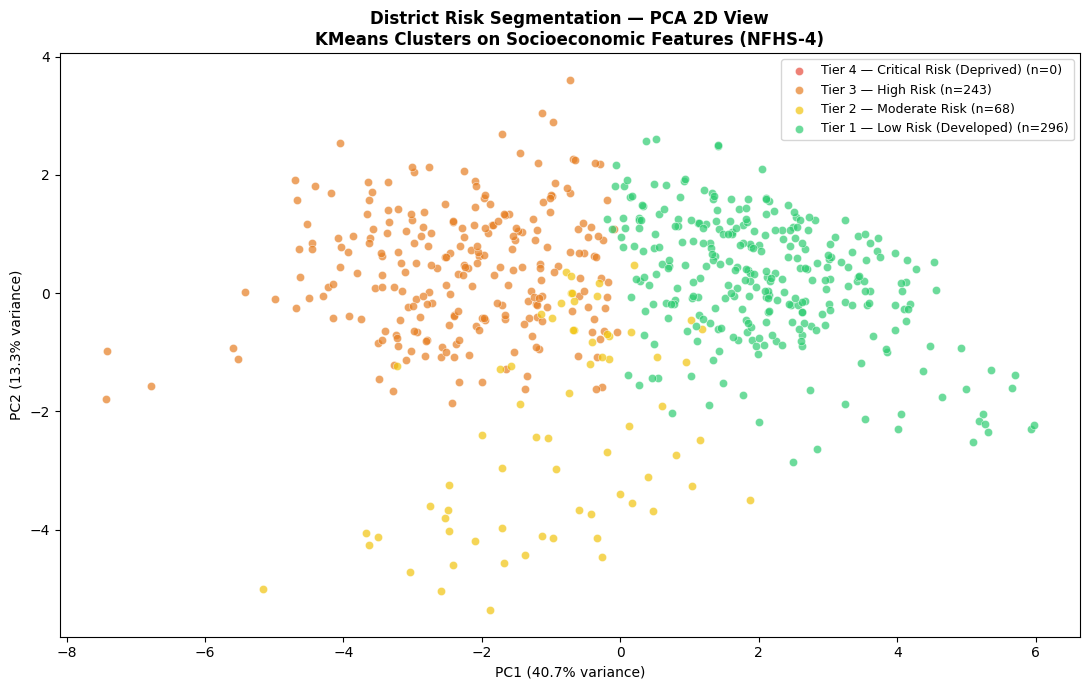

PCA variance explained: PC1=40.7%  PC2=13.3%  Total=54.0%


In [13]:
# PCA for 2D visualization of clusters
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
var_exp = pca.explained_variance_ratio_

df["pca1"] = X_pca[:, 0]
df["pca2"] = X_pca[:, 1]

Segment_order  = [
    "Tier 4 — Critical Risk (Deprived)",
    "Tier 3 — High Risk",
    "Tier 2 — Moderate Risk",
    "Tier 1 — Low Risk (Developed)"]
Segment_colours = {
    "Tier 4 — Critical Risk (Deprived)" : "#E74C3C",
    "Tier 3 — High Risk"                : "#E67E22",
    "Tier 2 — Moderate Risk"            : "#F1C40F",
    "Tier 1 — Low Risk (Developed)"     : "#2ECC71"}

fig, ax = plt.subplots(figsize=(11, 7))

for seg in Segment_order:
    mask = df["risk_segment"] == seg
    ax.scatter(df.loc[mask, "pca1"], df.loc[mask, "pca2"], label=f"{seg} (n={mask.sum()})", color=Segment_colours[seg], alpha=0.7, s=35, edgecolors="white", linewidth=0.4)

ax.set_xlabel(f"PC1 ({var_exp[0]*100:.1f}% variance)", fontsize=10)
ax.set_ylabel(f"PC2 ({var_exp[1]*100:.1f}% variance)", fontsize=10)
ax.set_title("District Risk Segmentation — PCA 2D View\n" "KMeans Clusters on Socioeconomic Features (NFHS-4)", fontsize=12, fontweight="bold")
ax.legend(fontsize=9, loc="upper right")
plt.tight_layout()
plt.savefig("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Outputs\\figures\\16_pca_clusters.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"PCA variance explained: PC1={var_exp[0]*100:.1f}%  "f"PC2={var_exp[1]*100:.1f}%  "f"Total={sum(var_exp)*100:.1f}%")

In [14]:
# Drop PCA helper columns before saving
df.drop(columns=["pca1", "pca2"], inplace=True)

df.to_csv("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Data\\processed\\nfhs4_final_segmented.csv", index=False)
joblib.dump(km_final, "C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Outputs\\models\\kmeans_model.pkl")

print(f"\n Final District Counts by Risk Segment ")
seg_summary = (df.groupby("risk_segment")[TARGET].agg(["count", "mean", "min", "max"]).round(1).rename(columns={"count":"Districts","mean":"Avg Stunting","min":"Min","max":"Max"}))
print(seg_summary.to_string())


 Final District Counts by Risk Segment 
                               Districts  Avg Stunting   Min   Max
risk_segment                                                      
Tier 1 — Low Risk (Developed)        296          30.8  12.4  55.8
Tier 2 — Moderate Risk                68          33.6  18.7  51.1
Tier 3 — High Risk                   243          43.8  25.1  65.1
